# CS-E-106: Data Modeling
## Fall 2019: Lecture 04

# HW04 covers all the code for Lecture 04-05 and Lab 04-05 material in python

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import ProbPlot

In [2]:
toluca_data  = pd.read_csv("data/toluca_data.csv")
toluca_data.shape

(25, 2)

**Note:** We use the formula version of the Ordinary Least Squares function here instead of `sm.OLS()` because the function `sm.stats.anova_lm()` only works on that version. So we can only get the ANOVA table if we use formula.

**statsmodels Homepage:** http://www.statsmodels.org/stable/index.html

**statsmodels.formula.api:** https://www.statsmodels.org/dev/example_formulas.html

In [3]:
toluca_data = toluca_data.rename(columns={"lotsize ":"lotsize"})
lm_formula = ols("workhrs ~ lotsize ", data=toluca_data).fit()
lm_formula.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                workhrs   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     105.9
Date:                Tue, 15 Oct 2019   Prob (F-statistic):           4.45e-10
Time:                        22:52:46   Log-Likelihood:                -131.64
No. Observations:                  25   AIC:                             267.3
Df Residuals:                      23   BIC:                             269.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3659     26.177      2.382      0.026       8.214     116.518
lotsize        3.5702      0.347     10.290      0.000       2.852       4.288
==============================================================================
Omnibus:                        0.608   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.684
Skew:                           0.298   Prob(JB):                        0.710
Kurtosis:                       2.450   Cond. No.                         202.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Emulating R regression plot in python:** https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

In [4]:
def get_calcs(model_fit):
    model_fitted_y = model_fit.fittedvalues

    # model residuals
    model_residuals = model_fit.resid

    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal

    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

    # absolute residuals
    model_abs_resid = np.abs(model_residuals)

    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag

    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    return(model_fitted_y, model_residuals, model_norm_residuals, \
           model_norm_residuals_abs_sqrt, model_abs_resid, \
           model_leverage, model_cooks)
           

In [5]:
model_fitted_y, model_residuals, model_norm_residuals, \
    model_norm_residuals_abs_sqrt, model_abs_resid, \
    model_leverage, model_cooks = get_calcs(model_fit=lm_formula)

model_fit=lm_formula

In [6]:
def resids_vs_fitted(df, y_str):
    
    
    plot_lm_1 = plt.figure(4)
#     plot_lm_1.set_figheight(8)
#     plot_lm_1.set_figwidth(12)

    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, y_str, data=df, 
                              lowess=True, 
                              scatter_kws={'alpha': 0.5}, 
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')

    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]

    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_residuals[i]));

def qq_plot(model_norm_residuals):
    
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]

    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i, 
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));
        


def scale_location_plot():
    plot_lm_3 = plt.figure(3)

    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

    for i in abs_sq_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_norm_residuals_abs_sqrt[i]));
        

def leverage_plot():

    plot_lm_4 = plt.figure(4)

    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(model_leverage, model_norm_residuals, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_4.axes[0].set_xlim(0, 0.20)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i, 
                                   xy=(model_leverage[i], 
                                       model_norm_residuals[i]))

    # shenanigans for cook's distance contours
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='red')

    p = len(model_fit.params) # number of model parameters

    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50), 
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50)) # 1 line
    plt.legend(loc='upper right');

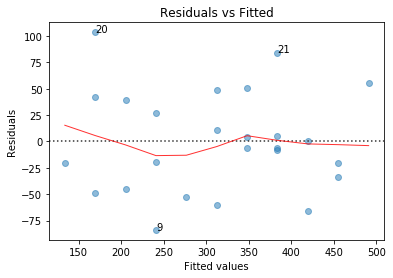

In [7]:
# fig, ax = plt.subplots(2,2, figsize=(10,10))
resids_vs_fitted(df=toluca_data, y_str="workhrs")

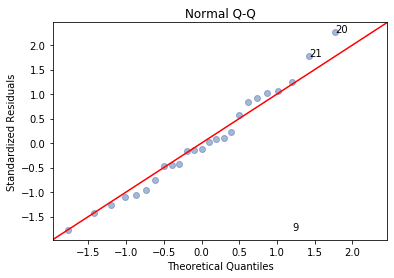

In [8]:
qq_plot(model_norm_residuals)

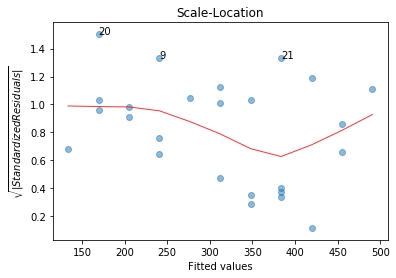

In [9]:
scale_location_plot()

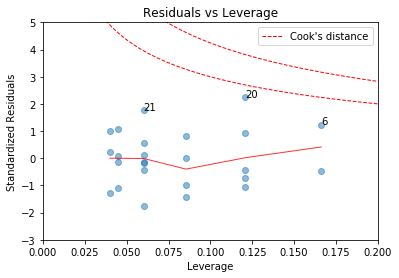

In [10]:
leverage_plot()

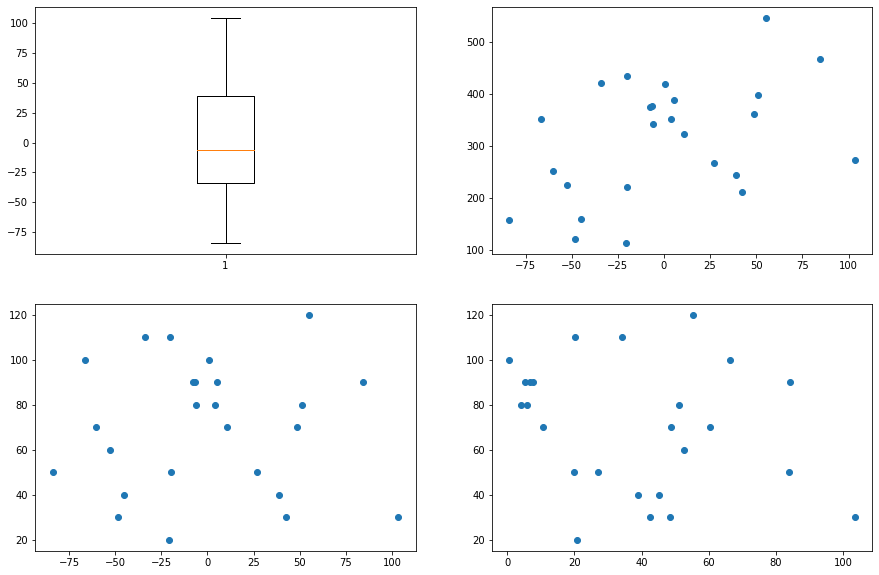

In [11]:
resids = lm_formula.resid
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].boxplot(resids)
ax[0,1].scatter(resids, toluca_data["workhrs"])
ax[1,0].scatter(resids, toluca_data["lotsize"])
ax[1,1].scatter(np.abs(resids), toluca_data["lotsize"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff96fc2d450>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff96fc33b10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff96fc2d410>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff96fc39590>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff96fc39a90>],
 'means': []}

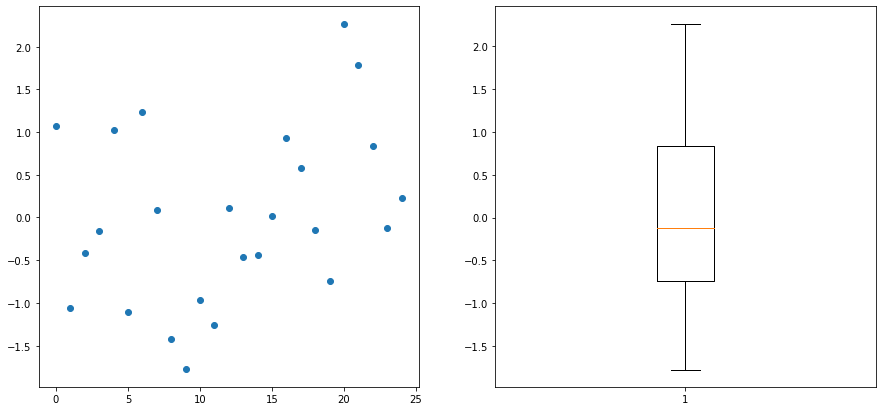

In [12]:
std_resids = lm_formula.get_influence().resid_studentized_internal
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(range(len(std_resids)), std_resids)
ax[1].boxplot(std_resids)

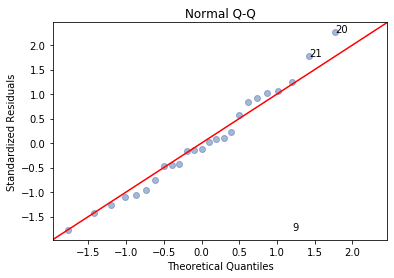

In [13]:
qq_plot(std_resids) # same exact plot as above

**Box-Cox Transformation**

In [32]:
y = toluca_data["workhrs"]
lmbdas = np.linspace(-5.0,5.0)
llf = np.zeros(lmbdas.shape, dtype=float)
for ii, lmbda in enumerate(lmbdas):
    llf[ii] = stats.boxcox_llf(lmbda, y)

In [33]:
y_most_normal, lmbda_optimal = stats.boxcox(y)

Text(0, 0.5, 'Box-Cox log-likelihood')

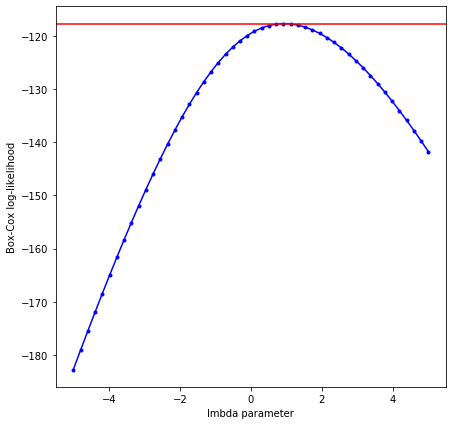

In [34]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.plot(lmbdas, llf, 'b.-')
ax.axhline(stats.boxcox_llf(lmbda_optimal, y), color='r')
ax.set_xlabel('lmbda parameter')
ax.set_ylabel('Box-Cox log-likelihood')

**Brown-Forsythe Test**

In [14]:
lm_formula.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                workhrs   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     105.9
Date:                Tue, 15 Oct 2019   Prob (F-statistic):           4.45e-10
Time:                        22:52:55   Log-Likelihood:                -131.64
No. Observations:                  25   AIC:                             267.3
Df Residuals:                      23   BIC:                             269.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3659     26.177      2.382      0.026       8.214     116.518
lotsize        3.5702      0.347     10.290      0.000       2.852       4.288
==============================================================================
Omnibus:                        0.608   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.684
Skew:                           0.298   Prob(JB):                        0.710
Kurtosis:                       2.450   Cond. No.                         202.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
toluca_data.lotsize.describe()

count     25.000000
mean      70.000000
std       28.722813
min       20.000000
25%       50.000000
50%       70.000000
75%       90.000000
max      120.000000
Name: lotsize, dtype: float64

In [16]:
bf_dat = pd.DataFrame((toluca_data.lotsize, resids), index=["lotsize","residuals"])
bf_dat = bf_dat.T
bf_dat

,lotsize,residuals
0,80.0,51.017980
1,30.0,-48.471919
2,50.0,-19.875960
3,90.0,-7.684040
4,70.0,48.720000
5,60.0,-52.577980
6,120.0,55.209899
7,80.0,4.017980
8,100.0,-66.386061
9,50.0,-83.875960


In [17]:
# Selecting rows less than the median value of 
# the lotsize (obtained above through summary()).
bf_dat1 = bf_dat[bf_dat["lotsize"]<=70]
bf_dat1

,lotsize,residuals
1,30.0,-48.471919
2,50.0,-19.875960
4,70.0,48.720000
5,60.0,-52.577980
9,50.0,-83.875960
10,40.0,-45.173939
11,70.0,-60.280000
13,20.0,-20.769899
16,30.0,42.528081
17,50.0,27.124040


In [18]:
# Selecting rows greater than the median value of 
# the lotsize (obtained above through summary()).
bf_dat2 = bf_dat[bf_dat["lotsize"]>=70]
bf_dat2

,lotsize,residuals
0,80.0,51.017980
3,90.0,-7.684040
4,70.0,48.720000
6,120.0,55.209899
7,80.0,4.017980
8,100.0,-66.386061
11,70.0,-60.280000
12,90.0,5.315960
14,110.0,-20.088081
15,100.0,0.613939


In [19]:
bf_dat1.describe()

,lotsize,residuals
count,13.000000,13.000000
mean,46.923077,-4.583030
std,17.021856,54.494138
min,20.000000,-83.875960
25%,30.000000,-48.471919
50%,50.000000,-19.875960
75%,60.000000,38.826061
max,70.000000,103.528081


In [20]:
d1i = np.abs(bf_dat1["residuals"]+19.876)
d1i

1      28.595919
2       0.000040
4      68.596000
5      32.701980
9      63.999960
10     25.297939
11     40.404000
13      0.893899
16     62.404081
17     47.000040
20    123.404081
22     58.702061
24     30.596000
Name: residuals, dtype: float64

In [21]:
np.mean(d1i)

44.81507692307691

**Breusch-Pagan Test** 

In [22]:
ei2 = lm_formula.resid**2
bp_df = pd.DataFrame((ei2, toluca_data.lotsize), index=["ei2","lotsize"]).T
f1 = ols(formula="ei2~lotsize", data=bp_df).fit()
f1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ei2   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.091
Date:                Tue, 15 Oct 2019   Prob (F-statistic):              0.307
Time:                        22:53:00   Log-Likelihood:                -231.86
No. Observations:                  25   AIC:                             467.7
Df Residuals:                      23   BIC:                             470.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3590.9081   1442.139      2.490      0.020     607.615    6574.201
lotsize      -19.9699     19.115     -1.045      0.307     -59.512      19.573
==============================================================================
Omnibus:                       12.996   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.781
Skew:                           1.498   Prob(JB):                      0.00277
Kurtosis:                       4.526   Cond. No.                         202.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
sm.stats.anova_lm(f1)

,df,sum_sq,mean_sq,F,PR(>F)
lotsize,1.0,7.896142e+06,7.896142e+06,1.091441,0.307009
Residual,23.0,1.663959e+08,7.234604e+06,NaN,NaN


In [24]:
sm.stats.anova_lm(lm_formula)

,df,sum_sq,mean_sq,F,PR(>F)
lotsize,1.0,252377.580808,252377.580808,105.875709,4.448828e-10
Residual,23.0,54825.459192,2383.715617,NaN,NaN


In [69]:
## Textbook formula
SSR1 = 7896142
SSE = 54825
n = 25
X_BP2 = (SSR1/2)/((SSE/n)**2)
X_BP2

0.8209329564761567